### FINAL PROJECT CSC578 Diana Bursac

The goal of the project is to explore  and compare different LSTM models and techiques 
for the Time series data forecast. The following topics are covered: 

- I. Importation 
- II. Data Visualisation & Data Exploration
- III. Data Preprocessing and Preparation for LSTM
- IV. Models (stateful, stateless and basic)
- V. RMSE and SMAPE comparison over the models
- VI. t-test for comparison


In [1]:
import pandas as pd
import numpy as np
from pandas import concat
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Flatten
from keras.layers import Activation,Dropout, BatchNormalization
from keras.constraints import maxnorm
from keras.optimizers import Adam
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from math import sqrt
from statsmodels.tsa.seasonal import seasonal_decompose
from dateutil.parser import parse
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from statsmodels.tsa.stattools import adfuller, kpss
EPSILON = 1e-10

Using TensorFlow backend.


#### 1. HOW TO IMPORT TIME SERIES IN PYTHON

The data for a time series typically contains the date column and the measured values.
We use the read_csv() in pandas package to read the time series dataset 
as a pandas dataframe. Adding the parse_dates=['date'] argument will make the date column 
to be parsed as a date field.

In [2]:
train_climate = pd.read_csv("train_data.csv", parse_dates=['Date Time'], index_col='Date Time')

In [3]:
train_climate.reset_index(inplace=True)

In [4]:
train_climate.tail()

,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
52561,2014-12-31 19:00:00,1006.20,2.27,274.94,1.96,97.8,7.19,7.04,0.16,4.36,6.99,1269.29,0.48,1.28,120.3
52562,2014-12-31 20:00:00,1006.28,2.14,274.81,1.89,98.2,7.13,7.00,0.13,4.34,6.96,1269.97,0.68,1.68,119.3
52563,2014-12-31 21:00:00,1006.69,1.96,274.60,1.72,98.3,7.04,6.92,0.12,4.29,6.87,1271.36,0.67,1.56,145.3
52564,2014-12-31 22:00:00,1006.92,1.94,274.56,1.75,98.6,7.03,6.93,0.10,4.29,6.88,1271.74,0.71,1.80,129.6
52565,2014-12-31 23:00:00,1007.11,2.18,274.78,2.01,98.8,7.15,7.06,0.09,4.37,7.01,1270.82,0.35,0.86,140.8


#### 2. EXPLORING AND VISUALIZING A TIME SERIES

In [5]:
# We can see that the Date Time has a datetime type  (instead of the object type)

train_climate.dtypes

Date Time          datetime64[ns]
p (mbar)                  float64
T (degC)                  float64
Tpot (K)                  float64
Tdew (degC)               float64
rh (%)                    float64
VPmax (mbar)              float64
VPact (mbar)              float64
VPdef (mbar)              float64
sh (g/kg)                 float64
H2OC (mmol/mol)           float64
rho (g/m**3)              float64
wv (m/s)                  float64
max. wv (m/s)             float64
wd (deg)                  float64
dtype: object

In [6]:
# No missing values

train_climate.isnull().sum()

Date Time          0
p (mbar)           0
T (degC)           0
Tpot (K)           0
Tdew (degC)        0
rh (%)             0
VPmax (mbar)       0
VPact (mbar)       0
VPdef (mbar)       0
sh (g/kg)          0
H2OC (mmol/mol)    0
rho (g/m**3)       0
wv (m/s)           0
max. wv (m/s)      0
wd (deg)           0
dtype: int64

#### Boxplot of Month-wise and Year-wise Distribution

We can group the data at seasonal intervals and see how the values are 
distributed over the year or month and how it compares over time.

In [7]:
train_climate['year'] = train_climate["Date Time"].apply(lambda x: x.year)
train_climate['month'] = train_climate["Date Time"].apply(lambda x: x.month)
train_climate['time_hour'] = train_climate["Date Time"].apply(lambda x: x.hour)

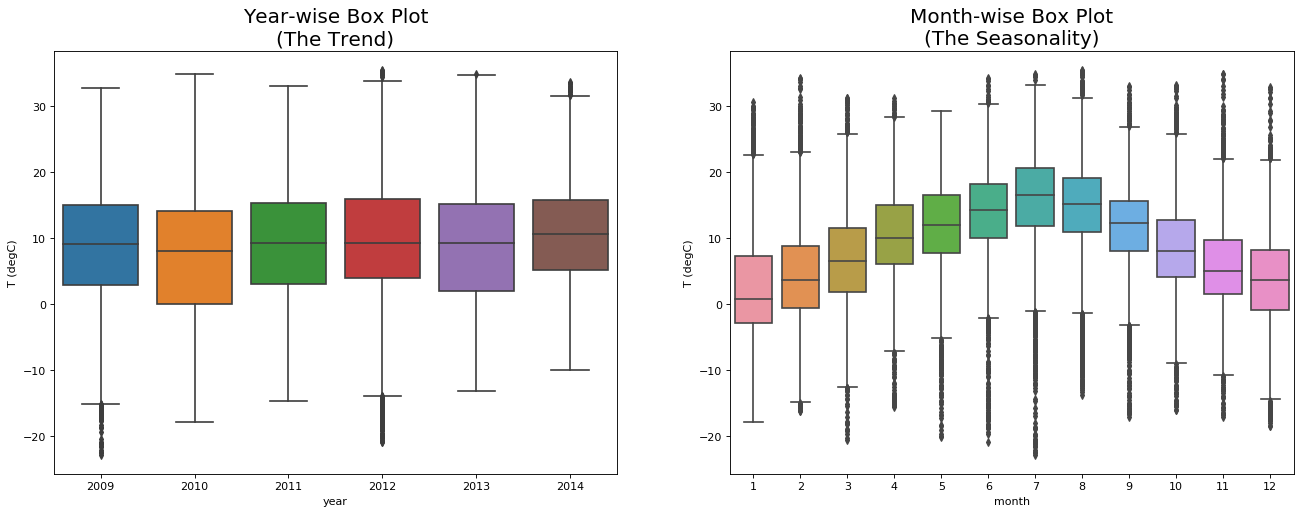

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# Draw Plot
fig, axes = plt.subplots(1, 2, figsize=(20,7), dpi= 80)
sns.boxplot(x='year', y='T (degC)', data=train_climate, ax=axes[0])
sns.boxplot(x='month', y='T (degC)', data= train_climate)

# Set Title
axes[0].set_title('Year-wise Box Plot\n(The Trend)', fontsize=18); 
axes[1].set_title('Month-wise Box Plot\n(The Seasonality)', fontsize=18)
plt.show()

Box plot of temperature reveals that the average temperature is almost constant 
over the years, while monthly plot shows that temperature is the highest in the middle
of the year that is month July.
The monthly wise boxplot shows that temperature tends to grow from January to July , 
it reaches its maximum in July and then again decreases in the second half of the year 
from July to December.

#### Visualizing a time series

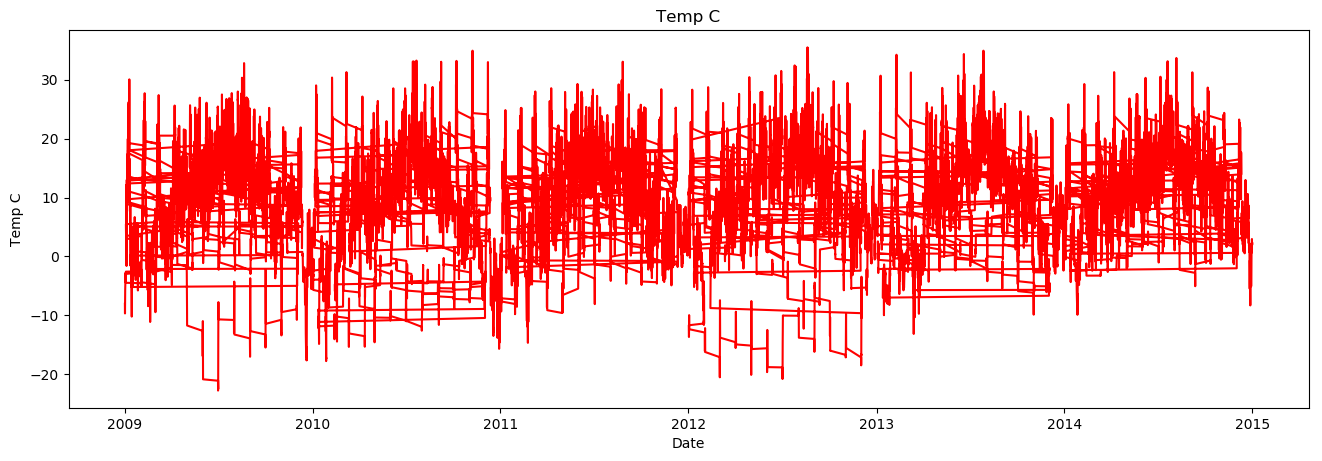

In [9]:
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
def plot_df(df, x, y, title="", xlabel='Date', ylabel='Temp C', dpi=100):
    plt.figure(figsize=(16,5), dpi=dpi)
    plt.plot(x, y, color='red')
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.show()

plot_df(train_climate, x=train_climate['Date Time'], y= train_climate['T (degC)'], title='Temp C')


There is an obvious seasonal trend in the temperature behaviors, since the temperatures 
reaches its peak every July in the year. However, as years progress, the temperature 
does neither increases no decreases. We can notice the presence of potential outliers 
since some values are not typical for some months over the year such as extremely high
temperature at the beginning of the year or very low temperature in the middle of the year.

#### Autocorrelation and partial autocorrelation

We want to check the similarity between observations as a function of the time lag between them.

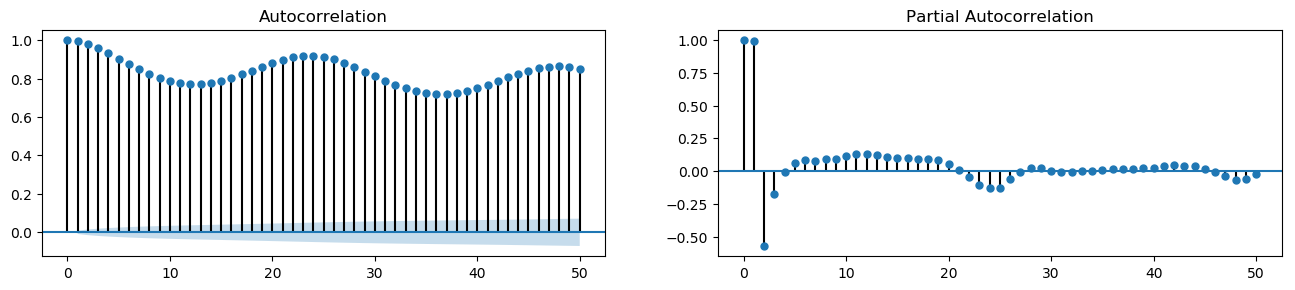

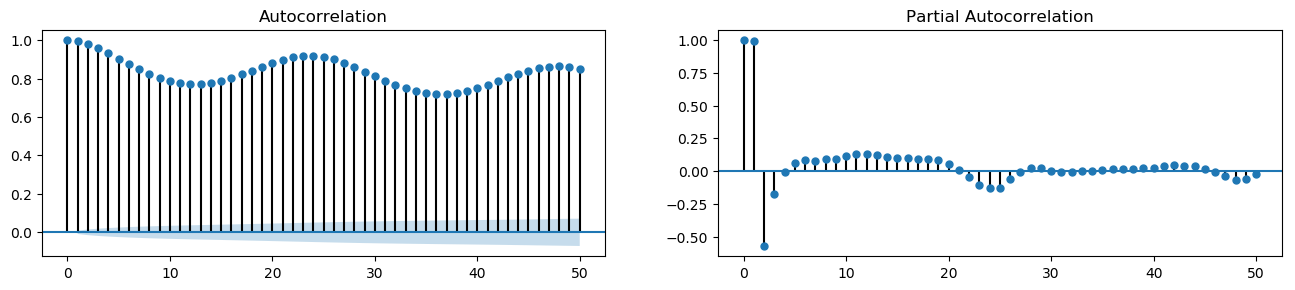

In [10]:
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Calculate ACF and PACF upto 50 lags
# acf_50 = acf(df.value, nlags=50)
# pacf_50 = pacf(df.value, nlags=50)

# Draw Plot
fig, axes = plt.subplots(1,2,figsize=(16,3), dpi= 100)
plot_acf(train_climate["T (degC)"].tolist(), lags=50, ax=axes[0])
plot_pacf(train_climate["T (degC)"].tolist(), lags=50, ax=axes[1])

In [11]:
#acf_50 = acf(train_climate["T (degC)"].tolist(), nlags=50)

In [12]:
#pacf_50 = pacf(train_climate["T (degC)"].tolist(), nlags=50)

#### Checking Stationary

Stationarity is a property of a time series. A stationary series is one where the values of the series is not a function of time.
In other words, the statistical properties of the series like mean, variance and autocorrelation are constant over time.

In [13]:
from statsmodels.tsa.stattools import adfuller, kpss
result = adfuller(train_climate["T (degC)"].values, autolag='AIC')
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')
for key, value in result[4].items():
    print('Critial Values:')
    print(f'   {key}, {value}')

ADF Statistic: -7.9483836588148655
p-value: 3.1743446225941923e-12
Critial Values:
   1%, -3.4304745333476085
Critial Values:
   5%, -2.8615950412401157
Critial Values:
   10%, -2.5667992966216273


#### 3. DATA PREPARATION FOR LSTM

- batch_size: 

- train and validation data split

- data scaling: train, validation and test data

- create LSTM time sequence data structure for both the train and the valid data set

- reshape data 

In [14]:
train_climate = train_climate[['Date Time','p (mbar)', 'T (degC)', 'Tpot (K)', 'Tdew (degC)',
       'rh (%)', 'VPmax (mbar)', 'VPact (mbar)', 'VPdef (mbar)', 'sh (g/kg)',
       'H2OC (mmol/mol)', 'rho (g/m**3)', 'wv (m/s)', 'max. wv (m/s)',
       'wd (deg)']]

#### Batch Size

The batch size is an important parameter since I decided to work with a stateful LSTM. 
The training set size, the testing set size and the validation set size must be entirely 
dividable by the batch size.
Since the test data was already provided, if we test all the values between 60-80,
the batch size of 73 guarantees that the test data length is entirely dividable by 73.
Further on approximately 33% of data was reserved for the validation set, where
we have to pay attention that the train length and the valid length are entirely 
dividable by 73 that is our chosen batch size.


#### Train and Validation set size


In [15]:
# TRAIN -VALID LENGTH SIZE

# since later in the code by using 'def create_data_structure' we have to drop the first
# 24 records (NaN), I have to make sure that the chosen size for the train set gives
# modulo = 24 when divided by 73. Once we drop those 24 records (modulo) the remain
# length is divided by 73. The same is for the valid data set.
# We look for all possible lenghts in the range that will return modulo = 24, and choose
# the max one

batch_size = [73]
def train_valid_length(train_set, batch_size, valid_percent):
    train_l = {}
    valid_l = {}
    for batch in batch_size:
        length = len(train_set) - round(len(train_set)*valid_percent)
        train_len = []
        for x in range(length-100, length):
            modulo = x%batch
            if modulo ==24:
                train_len.append(x)
        train_l["l"+str(batch)] = max(train_len)
        valid_l["l"+str(batch)] = len(train_set) - max(train_len)
        moduol1 = valid_l["l"+str(batch)]%batch
        print(moduol1)
        valid_l["l"+str(batch)] = valid_l["l"+str(batch)] - moduol1+ 24
    return train_l, valid_l

In [16]:
def train_valid_data(data, batch_size):
    d_train = {}
    d_valid = {}
    for len_batch in ['l73']:
        train_l, valid_l = train_valid_length(data, batch_size, \
                                                    valid_percent = 0.33)
    
        d_train[len_batch] = data[0:train_l[len_batch]]
        d_valid[len_batch] = data[-valid_l[len_batch]:]
        #d_valid[len_batch] = data[train_l[len_batch]:]
    return d_train, d_valid

In [17]:
d_train, d_valid = train_valid_data(train_climate, batch_size = [73])

55


In [18]:
train_data_73 = d_train["l73"]
valid_data_73 = d_valid["l73"]

In [19]:
# since we have to keep the sequence order, the first 35210 records out of total 
# 52566 records are reserved for the train set and the last 17325 for the valid set.
# The total length for both is 52535 that means that we lose 31 records while adjusting 
# the validation set size, but this can be neglected since the valid set is still
# large enough for further analysis.

train_data_73.shape, valid_data_73.shape


((35210, 15), (17325, 15))

In [20]:
columns_new = ['p (mbar)', 'T (degC)', 'Tpot (K)', 'Tdew (degC)',
       'rh (%)', 'VPmax (mbar)', 'VPact (mbar)', 'VPdef (mbar)', 'sh (g/kg)',
       'H2OC (mmol/mol)', 'rho (g/m**3)', 'wv (m/s)', 'max. wv (m/s)',
       'wd (deg)']

#### Create LSTM time sequence data structure

In [21]:

def create_data_structure(data, columns, n_x =24, n_y=1, dropnan=True):
    df = pd.DataFrame(data, columns = columns)
    no_features = df.shape[1]
    data_sequence = list()
    features = list()
    # input sequence X(t-24,t-23 ... t-1) ,
    for i in range(n_x, 0, -1):
        data_sequence.append(df.shift(i))
        features +=[(df.columns[j]+ ", v(t-{})".format(i)) for j in range(no_features)]
    # predict sequence Y(t); predict next hour temp, based on the previous 24 hours
    for i in range(0, n_y):
        data_sequence.append(df['T (degC)'].shift(-i))
        features+=['T (degC)' + ", v(t+{})".format(i)]
    data_sequence= concat(data_sequence, axis =1)
    data_sequence.dropna(inplace=True) # we drop first 24 records
    data_sequence.columns = features
    return data_sequence

In [22]:
def train_valid_data(data):
    y = data.iloc[:,-1]
    x = data.iloc[:,0:-1]
    return x, y

#### Reshape data

In [23]:
def lstmData_shape(x,y, timesteps = 24, dim = 14):
    x, y = np.array(x), np.array(y)
    x = np.reshape(x, (x.shape[0], timesteps, dim))
    return x,y

#### 1.step: Data Scaling (train and valid)

Since LSTM-RNN is very sensitive to the scale of the inputs, and since the default 
activation function is 'tanh' , we use the min-max scaling with range [-1,1].
The train and the valid data are scaled separately. We fit on the train data, meaning
we learn the parameters of scaling on the train data, and use them to transform
the train data, the valid data set and the test set that can be see later in the code.

In [24]:
#  1.step: Once we get the train and the valid set, we should scale them separately 

scaler = MinMaxScaler(feature_range=(-1, 1))
scaler.fit(train_data_73.iloc[:, 1:])
train_data_73_sc = scaler.transform(train_data_73.iloc[:, 1:])
valid_data_73_sc = scaler.transform(valid_data_73.iloc[:, 1:])



#### 2.step: The time sequence for LSTM (train and valid data set)

The train set has 337 columns (including 'y' column) 
where 14 climate measurements over 24 hours are concatenated (i.e., 336 = 14 * 24).
The columns are marked from v(t-24) to v(t-1).

Below I confirmed that the first entry in x_train spans from 01.01.2009 01:00:00 to 02.01.2009 00:00:00, both inclusive, and that the first entry in y_train is the temperature of 02.01.2009 01:00:00.


In [25]:

train_all_columns = create_data_structure(train_data_73,train_climate.columns, \
                                          n_x =24, n_y=1,dropnan=True)

In [26]:
# 2.step: we use the scaled data from step_1 to create the time sequence of concatenated measurements over 24 hours 
# the train data set after transformation has  337 columns including 'y_train' column

train = create_data_structure(train_data_73_sc,columns_new, n_x =24, n_y=1, dropnan=True)

In [27]:
train.head()

,"p (mbar), v(t-24)","T (degC), v(t-24)","Tpot (K), v(t-24)","Tdew (degC), v(t-24)","rh (%), v(t-24)","VPmax (mbar), v(t-24)","VPact (mbar), v(t-24)","VPdef (mbar), v(t-24)","sh (g/kg), v(t-24)","H2OC (mmol/mol), v(t-24)",...,"VPmax (mbar), v(t-1)","VPact (mbar), v(t-1)","VPdef (mbar), v(t-1)","sh (g/kg), v(t-1)","H2OC (mmol/mol), v(t-1)","rho (g/m**3), v(t-1)","wv (m/s), v(t-1)","max. wv (m/s), v(t-1)","wd (deg), v(t-1)","T (degC), v(t+0)"
24,0.655348,-0.494849,-0.504180,-0.286891,0.871176,-0.916945,-0.795614,-0.990889,-0.799308,-0.796699,...,-0.880697,-0.714912,-0.985615,-0.720415,-0.717637,0.398045,-0.934817,-0.913428,-0.138650,-0.370879
25,0.657895,-0.523352,-0.532844,-0.330959,0.843570,-0.924336,-0.816667,-0.989930,-0.820069,-0.817550,...,-0.879641,-0.707018,-0.988012,-0.713495,-0.709818,0.392775,-0.955485,-0.901623,-0.176994,-0.365728
26,0.662564,-0.520948,-0.531138,-0.326063,0.850472,-0.923984,-0.814035,-0.990410,-0.817301,-0.814944,...,-0.877881,-0.702632,-0.988492,-0.707958,-0.705474,0.385115,-0.922099,-0.913428,0.165879,-0.371223
27,0.665747,-0.529190,-0.539669,-0.342088,0.829768,-0.926095,-0.821053,-0.988971,-0.824221,-0.822763,...,-0.879641,-0.706140,-0.988971,-0.712111,-0.708949,0.387995,-0.896661,-0.901623,0.129758,-0.375687
28,0.675722,-0.549107,-0.560826,-0.370131,0.820566,-0.930670,-0.833333,-0.988971,-0.836678,-0.834926,...,-0.881401,-0.707895,-0.989930,-0.713495,-0.710686,0.388853,-0.877583,-0.864240,0.056960,-0.388736


In [28]:
#The first entry in xtrain spans from

train_all_columns.loc[24, 'Date Time, v(t-24)'], \
train_all_columns.loc[24, 'Date Time, v(t-1)']

(Timestamp('2009-01-01 01:00:00'), Timestamp('2009-02-01 00:00:00'))

In [29]:
train_all_columns.loc[25, 'Date Time, v(t-1)']

Timestamp('2009-02-01 01:00:00')

In [30]:
#the first entry in ytrain is the temperature of 02.01.2009 01:00:00.

train_all_columns.loc[24, 'T (degC), v(t+0)']==train_all_columns.loc[25, 'T (degC), v(t-1)']

True

In [31]:
# the train data set after transformation has  337 columns including 'y_train' column 

train = create_data_structure(train_data_73_sc,columns_new, n_x =24, n_y=1, dropnan=True)

In [32]:
# the valid data set after transformation has  337 columns including 'y_valid' column

valid = create_data_structure(valid_data_73_sc,columns_new, n_x =24, n_y=1, dropnan=True)

In [33]:
train.shape, valid.shape

((35186, 337), (17301, 337))

#### 3.step: Define x_train and y_train

In [34]:
# separate x_train and y_train as well as x_valid and y_valid

x_train, y_train = train_valid_data(train)
x_valid, y_valid = train_valid_data(valid)

#### 4.step: Scale x_test and create y_test 

In [35]:
# import x_test

x_test = pd.read_csv("test_data.csv", header = None)
x_test.head()

,0,1,2,3,4,5,6,7,8,9,...,326,327,328,329,330,331,332,333,334,335
0,1007.19,2.06,274.65,1.89,98.8,7.09,7.00,0.09,4.34,6.95,...,92.0,6.83,6.29,0.55,3.91,6.27,1268.31,3.10,4.61,157.8
1,1007.06,2.22,274.82,2.06,98.9,7.17,7.09,0.08,4.39,7.04,...,89.8,6.94,6.23,0.71,3.88,6.22,1266.15,2.74,4.37,157.9
2,1007.43,2.04,274.61,1.87,98.8,7.08,6.99,0.08,4.33,6.94,...,89.8,6.91,6.20,0.70,3.86,6.20,1265.64,1.05,2.68,135.9
3,1007.87,1.79,274.34,1.63,98.8,6.95,6.87,0.08,4.25,6.82,...,88.9,6.98,6.20,0.77,3.87,6.20,1264.11,1.67,2.96,97.5
4,1007.79,2.12,274.66,1.99,99.1,7.12,7.05,0.06,4.36,7.00,...,81.6,7.27,5.93,1.34,3.70,5.94,1259.97,2.36,4.45,161.3


#### Test data scaling

In [36]:
# We scale the test set by using the 'scaler' that was already fitted with the original
# train set. Since the original train set was a structure of 14 columns (without Date Time)
# and the current test set structure has 14 columns concatenate over 24 hours (336 columns),
# we have to iterate over 336 columns, where each step is 14, in order to scale
# the values. Min max scaler transform expects that input shape has 
# 14 columns, since the original train set used for "fit" had that structure.
# once the test data was scaled, we create the y_test (with scaled values)

x_test.columns = x_train.columns
l1 = len(x_test.columns) # number of columns
test_data_sc = []
for i in range(0, l1, 14): 
    x_test_sc = scaler.transform(x_test.iloc[:,i:i+14])
    test_data_sc.append(pd.DataFrame(x_test_sc))
test_data_sc = pd.concat(test_data_sc, axis =1)
test_data_sc.columns = x_train.columns
# add y_test
y_test = []
for i  in range(1, test_data_sc.shape[0]):
    y_test.append(test_data_sc.loc[i,"T (degC), v(t-1)"])
y_test.append(y_test[-1]) # last column 
y_test_df = pd.DataFrame(y_test, columns = ["T (degC), v(t+0)"])
test = pd.concat([test_data_sc, y_test_df], axis =1)

In [37]:
test.shape

(17447, 337)

In [38]:
# we separate x_test and y_test

x_test, y_test = train_valid_data(test)

#### 5.step: Reshape x_train, x_valid and x_test

In [39]:
# data reshape

x_train, y_train = lstmData_shape(x_train,y_train, timesteps = 24, dim = 14)
x_valid, y_valid = lstmData_shape(x_valid,y_valid, timesteps = 24, dim = 14)
x_test, y_test = lstmData_shape(x_test,y_test, timesteps = 24, dim = 14)

In [40]:
# statefull: in memorizes the last cell of batch 1, this is now an input to the
# first cell of batch2

In [41]:
# return_sequence: False: return one output at the last cell/node
# return sequence: True: return one output at each cell

### 4. MODELS

#### 4.1 Stateful LSTM stacked with 2 layers

The five different stacked LSTM networks are created with 2 hidden layers and the same number of units at each layer. The observed number of units is:  1, 4, 8, 16 and 32. 

Explanation of some parameters:
- Shuffle = False: we do not shuffle because we're dealing with sequences and if we would shuffle, we would break the whole order of measurements
- Stateful = True
- The number of epochs = 1 because we will call this fit method for 35 epochs. And then Reset states: when the training is finished for an epoch, we need to reset all states which are hidden state and cell state
- Return-sequence = True: we return the output of each cell state
- Return-sequence = False: we return the output at the last cell

In [42]:
def create_model(x_train, y_train, x_valid, y_valid, N, batch_size, no_epochs):
    loss, valid_loss =list(), list()
    model = Sequential()
    model.add(LSTM(N, batch_input_shape = (batch_size, x_train.shape[1], x_train.shape[2]), \
                   stateful = True,return_sequences = True))
    #model.add(Dropout(0.3))
    model.add(LSTM(N, batch_input_shape = (batch_size, x_train.shape[1], x_train.shape[2]), \
                   stateful = True, return_sequences = False))
    #model.add(Dropout(0.3))
    model.add(Dense(1))
    model.compile(loss ="mse", optimizer ="adam")
    loss, valid_loss = list(), list()
    for i in range(no_epochs):
        #print("Epoch: " + str(i))
        history = model.fit(x_train,y_train, shuffle=False, epochs = 1, \
                            batch_size=batch_size, verbose = 0, validation_data=(x_valid, y_valid))
        
        loss.append(history.history['loss'])
        valid_loss.append(history.history['val_loss'])
        model.reset_states()
    return model, loss, valid_loss              

In [43]:
model1, loss1, valid_loss1 = create_model(x_train, y_train, x_valid, y_valid,\
                    N =1 ,batch_size =73, no_epochs = 35 )
model4, loss4, valid_loss4 = create_model(x_train, y_train, x_valid, y_valid,\
                    N =4 ,batch_size =73, no_epochs = 35 )
model8, loss8, valid_loss8 = create_model(x_train, y_train, x_valid, y_valid, \
                    N =8 , batch_size =73, no_epochs = 35)
model16, loss16, valid_loss16 = create_model(x_train, y_train, x_valid, y_valid,\
                    N =16 , batch_size =73, no_epochs = 35)
model32, loss32, valid_loss32 = create_model(x_train, y_train, x_valid, y_valid,\
                    N =32 , batch_size =73, no_epochs = 35)
    

In [46]:
def model_predict(model, x_test,batch_size):
    yhat = model.predict(x_test, batch_size = batch_size)
    return yhat
                  

In [47]:

def data_inversion(y_data):
    scaler = MinMaxScaler(feature_range=(-1, 1))
    scaler.fit_transform(train_data_73['T (degC)'].values.reshape(-1, 1))
    y_data_inv = scaler.inverse_transform(y_data.reshape(-1, 1))
    return y_data_inv
    

In [48]:

def calculate_error(yhat_inv, y_test_inv):
    rmse = sqrt(mean_squared_error(y_test_inv, yhat_inv))
    smape = np.mean(2.0 * np.abs(y_test_inv - yhat_inv) / ((np.abs(y_test_inv)\
                                                    + np.abs(yhat_inv)) + EPSILON))
    print('Test RMSE: %.3f' % rmse)
    print('Test SMAPE: %.3f' % smape)
    return rmse, smape
    

In [49]:
yhat1 = model_predict(model1, x_test, batch_size =73)
yhat4 = model_predict(model4, x_test, batch_size =73)
yhat8 = model_predict(model8, x_test, batch_size =73)
yhat16 = model_predict(model16, x_test, batch_size =73)
yhat32 = model_predict(model32, x_test, batch_size =73)


In [50]:
x_test_date = pd.read_csv('sample_submission_2019spring (1).csv', \
                          parse_dates=['date time'], index_col='date time')
x_test_date.reset_index(inplace=True)

In [51]:
yhat1_inv = data_inversion(yhat1)
yhat4_inv = data_inversion(yhat4)
yhat8_inv = data_inversion(yhat8)
yhat16_inv = data_inversion(yhat16)
yhat32_inv = data_inversion(yhat32)
y_test_inv = data_inversion(y_test)

In [52]:
rmse1, smape1 = calculate_error(yhat1_inv, y_test_inv)

Test RMSE: 1.004
Test SMAPE: 0.139


In [53]:
rmse4, smape4 = calculate_error(yhat4_inv, y_test_inv)

Test RMSE: 0.892
Test SMAPE: 0.131


In [54]:
rmse8, smape8 = calculate_error(yhat8_inv, y_test_inv)

Test RMSE: 0.790
Test SMAPE: 0.125


In [55]:
rmse16, smape16 = calculate_error(yhat16_inv, y_test_inv)

Test RMSE: 0.798
Test SMAPE: 0.121


In [56]:
rmse32, smape32 = calculate_error(yhat32_inv, y_test_inv)

Test RMSE: 0.745
Test SMAPE: 0.121


In [57]:
def loss_train_valid(loss, val_loss, model, N):
    epochs = [i for i in range(35)]
    plt.plot(epochs, loss)
    plt.plot(epochs, val_loss)
    plt.title("{} loss: stateful LSTM {}-{}". format(model, N, N))
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['training', 'validation'], loc='best')
    plt.show()

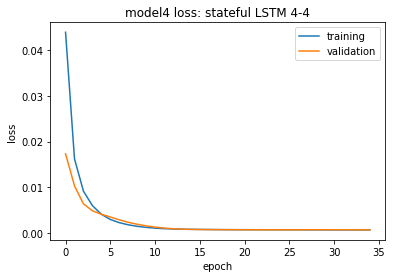

In [58]:
loss_train_valid (loss4, valid_loss4, 'model4', 4)

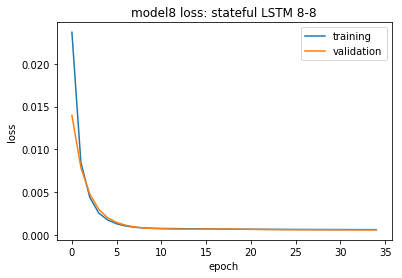

In [59]:
loss_train_valid (loss8, valid_loss8, 'model8', 8)

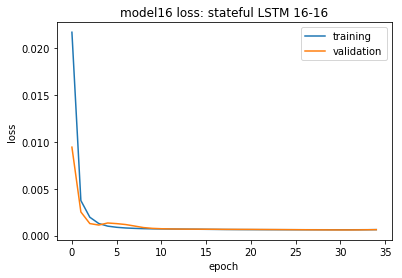

In [60]:
loss_train_valid (loss16, valid_loss16, 'model16', 16)

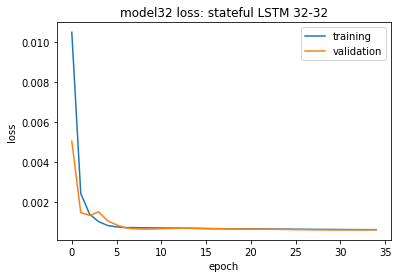

In [61]:
loss_train_valid (loss32, valid_loss32, 'model32', 32)

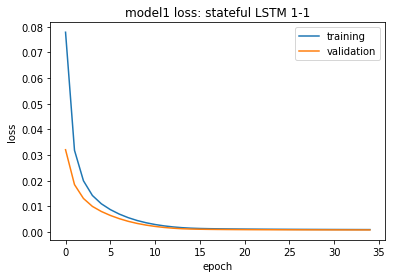

In [62]:
loss_train_valid (loss1, valid_loss1, 'model1', 1)

In [63]:
def plot_prediction(yhat_inv, y_test_inv, i):
    fig = plt.figure()
    ax1 = fig.add_subplot(111)
    ax1.scatter(range(len(yhat_inv)),y_test_inv,alpha = 0.5,lw =0, s=10, c='b',label='test values')
    ax1.scatter(range(len(yhat_inv)),yhat_inv,alpha = 0.5,lw =0, s=10, c='r', label='predictions')
    plt.legend(loc='upper left')
    plt.title("test vs prediction: stateful: LSTM-{}-{}". format(i,i))
    plt.show()

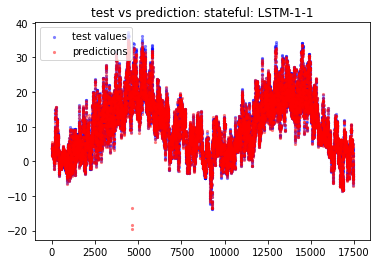

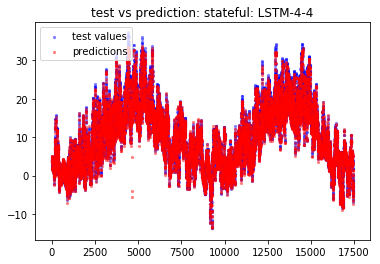

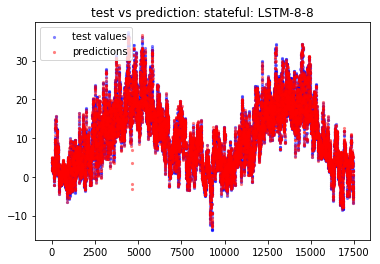

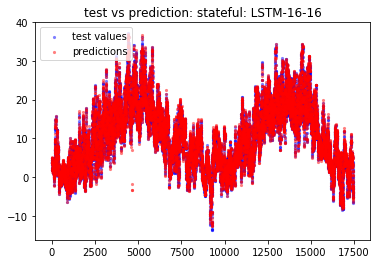

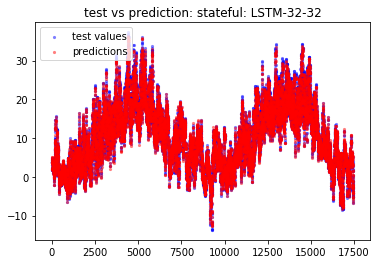

In [64]:
plot_prediction(yhat1_inv, y_test_inv, 1)
plot_prediction(yhat4_inv, y_test_inv, 4)
plot_prediction(yhat8_inv, y_test_inv, 8)
plot_prediction(yhat16_inv, y_test_inv, 16)
plot_prediction(yhat32_inv, y_test_inv, 32)

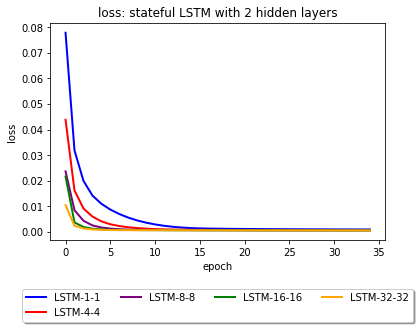

In [97]:
# train loss comaprison over all five models

loss = [loss1, loss4, loss8, loss16, loss32]
color = ["blue", "red", "purple","green", "orange"]
model = ["LSTM-1-1", "LSTM-4-4", "LSTM-8-8", "LSTM-16-16", "LSTM-32-32"]
epochs = [i for i in range(35)]
for l, c, m in zip(loss, color, model):
    plt.plot(epochs, l, color = c, lw = 2,label = m)
plt.title("loss: stateful LSTM with 2 hidden layers")
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2), fancybox=True , shadow=True, ncol=4)
plt.show()

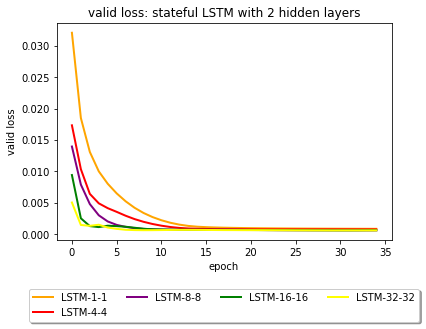

In [66]:
# valid loss comaprison over all five models

val_loss = [valid_loss1, valid_loss4, valid_loss8, valid_loss16, valid_loss32]
color = ["orange", "red", "purple","green", "yellow"]
model = ["LSTM-1-1", "LSTM-4-4", "LSTM-8-8", "LSTM-16-16", "LSTM-32-32"]
epochs = [i for i in range(35)]
for l, c, m in zip(val_loss, color, model):
    plt.plot(epochs, l, color = c, lw = 2,label = m)
plt.title("valid loss: stateful LSTM with 2 hidden layers")
plt.ylabel('valid loss')
plt.xlabel('epoch')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2), fancybox=True , shadow=True, ncol=4)
plt.show()

In [68]:
submission = x_test_date.drop(columns = ["temperature"])

In [69]:
submission.index.values

array([    0,     1,     2, ..., 17444, 17445, 17446])

In [70]:
yhat8_df = pd.DataFrame(yhat8_inv, index = submission.index.values)
yhat16_df = pd.DataFrame(yhat16_inv, index = submission.index.values)
yhat32_df = pd.DataFrame(yhat32_inv, index = submission.index.values)


In [71]:
submission_new = pd.concat([submission,yhat8_df, yhat16_df, yhat32_df ], axis =1)

In [72]:
submission_new.head()

,date time,0,0,0
0,2015-02-01 00:00:00,1.505622,1.378430,1.681670
1,2015-02-01 01:00:00,1.896046,1.836681,2.069196
2,2015-02-01 02:00:00,1.851700,1.694358,1.973983
3,2015-02-01 03:00:00,2.037310,1.878889,2.078671
4,2015-02-01 04:00:00,2.663939,2.450444,2.523680


In [73]:
head = ['date time','yhat8_sf', 'yhat16_sf', 'yhat32_sf']
submission_new.to_csv('NEW_submission_FP_LSTM_SF_2.csv', index=False, header=head)

#### 4.2. Stateless LSTM stacked with 2 layers

The five different stacked LSTM networks are created with 2 hidden layers and the same number of units at each layer. The observed number of neurons is:  1, 4, 8, 16 and 32.

- Stateful = False
- In the stateless LSTM configuration, internal state is reset after each training batch


In [75]:
def create_model_sl(x_train, y_train, x_valid, y_valid, N, batch_size, no_epochs):
    model = Sequential()
    model.add(LSTM(N, batch_input_shape = (batch_size, x_train.shape[1], x_train.shape[2]), \
                   stateful = False,return_sequences = True))
    #model.add(Dropout(0.3))
    model.add(LSTM(N, batch_input_shape = (batch_size, x_train.shape[1], x_train.shape[2]), \
                   stateful = False, return_sequences = False))
    #model.add(Dropout(0.3))
    model.add(Dense(1))
    model.compile(loss ="mse", optimizer ="adam")
    history = model.fit(x_train,y_train, shuffle=False, epochs = no_epochs, \
                            batch_size=batch_size, verbose = 0, validation_data=(x_valid, y_valid))
    return model, history 

In [76]:
model1_sl, history1_sl = create_model_sl(x_train, y_train, x_valid, y_valid,\
                    N =1 ,batch_size =73, no_epochs = 35 )
model4_sl, history4_sl = create_model_sl(x_train, y_train, x_valid, y_valid,\
                    N =4 ,batch_size =73, no_epochs = 35 )
model8_sl, history8_sl = create_model_sl(x_train, y_train, x_valid, y_valid, \
                    N =8 , batch_size =73, no_epochs = 35)
model16_sl, history16_sl = create_model_sl(x_train, y_train, x_valid, y_valid,\
                    N =16 , batch_size =73, no_epochs = 35)
model32_sl, history32_sl = create_model_sl(x_train, y_train, x_valid, y_valid,\
                    N =32 , batch_size =73, no_epochs = 35)

In [81]:
yhat1_sl = model_predict(model1_sl, x_test, batch_size =73)
yhat4_sl = model_predict(model4_sl, x_test, batch_size =73)
yhat8_sl = model_predict(model8_sl, x_test, batch_size =73)
yhat16_sl = model_predict(model16_sl, x_test, batch_size =73)
yhat32_sl = model_predict(model32_sl, x_test, batch_size =73)

In [82]:
yhat1_inv_sl = data_inversion(yhat1_sl)
yhat4_inv_sl = data_inversion(yhat4_sl)
yhat8_inv_sl = data_inversion(yhat8_sl)
yhat16_inv_sl = data_inversion(yhat16_sl)
yhat32_inv_sl = data_inversion(yhat32_sl)
y_test_inv = data_inversion(y_test)

In [83]:
rmse1_sl, smape1_sl = calculate_error(yhat1_inv_sl, y_test_inv)

Test RMSE: 1.280
Test SMAPE: 0.150


In [84]:
rmse4_sl, smape4_sl = calculate_error(yhat4_inv_sl, y_test_inv)

Test RMSE: 0.835
Test SMAPE: 0.151


In [85]:
rmse8_sl, smape8_sl = calculate_error(yhat8_inv_sl, y_test_inv)

Test RMSE: 0.749
Test SMAPE: 0.127


In [86]:
rmse16_sl, smape16_sl = calculate_error(yhat16_inv_sl, y_test_inv)

Test RMSE: 0.755
Test SMAPE: 0.125


In [87]:
rmse32_sl, smape32_sl = calculate_error(yhat32_inv_sl, y_test_inv)

Test RMSE: 0.796
Test SMAPE: 0.122


In [112]:
def plot_prediction(yhat_inv, y_test_inv, i):
    fig = plt.figure()
    ax1 = fig.add_subplot(111)
    ax1.scatter(range(len(yhat_inv)),y_test_inv,alpha = 0.5,lw =0, s=10, c='b',label='test values')
    ax1.scatter(range(len(yhat_inv)),yhat_inv,alpha = 0.5,lw =0, s=10, c='r', label='predictions')
    plt.legend(loc='upper left')
    plt.title("test vs prediction: stateless: LSTM-{}-{}". format(i,i))
    plt.show()

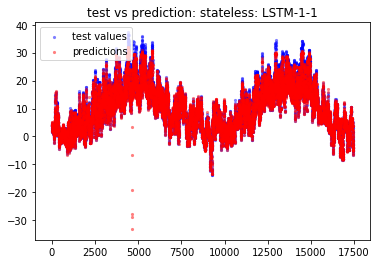

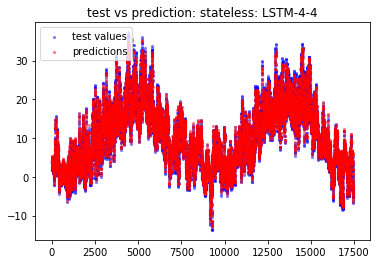

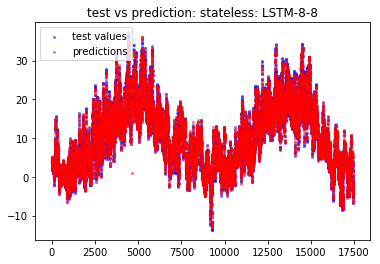

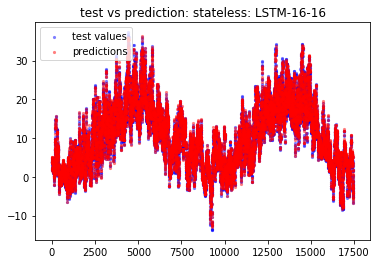

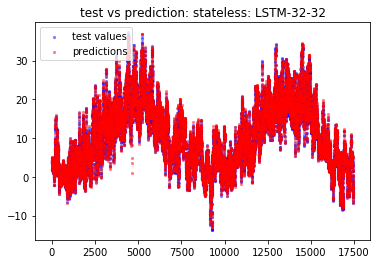

In [113]:
plot_prediction(yhat1_inv_sl, y_test_inv, 1)
plot_prediction(yhat4_inv_sl, y_test_inv, 4)
plot_prediction(yhat8_inv_sl, y_test_inv, 8)
plot_prediction(yhat16_inv_sl, y_test_inv, 16)
plot_prediction(yhat32_inv_sl, y_test_inv, 32)

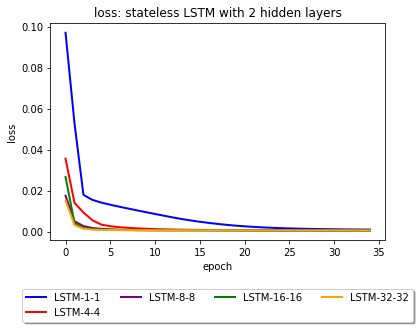

In [90]:
loss1_sl, loss4_sl, loss8_sl, loss16_sl, loss32_sl = history1_sl.history["loss"],\
history4_sl.history["loss"], history8_sl.history["loss"], \
history16_sl.history["loss"], history32_sl.history["loss"]

loss = [loss1_sl, loss4_sl, loss8_sl, loss16_sl, loss32_sl]
color = ["blue", "red", "purple","green", "orange"]
model = ["LSTM-1-1", "LSTM-4-4", "LSTM-8-8", "LSTM-16-16", "LSTM-32-32"]
epochs = [i for i in range(35)]
for l, c, m in zip(loss, color, model):
    plt.plot(epochs, l, color = c, lw = 2,label = m)
plt.title("loss: stateless LSTM with 2 hidden layers")
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2), fancybox=True , shadow=True, ncol=4)
plt.show()

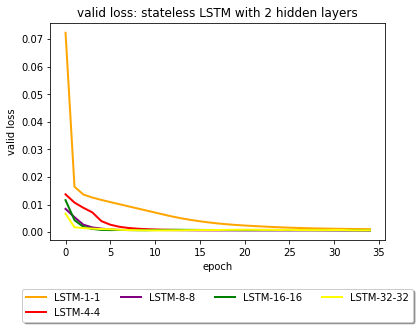

In [91]:
valid_loss1_sl, valid_loss4_sl, valid_loss8_sl, valid_loss16_sl, valid_loss32_sl = history1_sl.history["val_loss"],\
history4_sl.history["val_loss"], history8_sl.history["val_loss"], \
history16_sl.history["val_loss"], history32_sl.history["val_loss"]

val_loss = [valid_loss1_sl, valid_loss4_sl, valid_loss8_sl, valid_loss16_sl, valid_loss32_sl]
color = ["orange", "red", "purple","green", "yellow"]
model = ["LSTM-1-1", "LSTM-4-4", "LSTM-8-8", "LSTM-16-16", "LSTM-32-32"]
epochs = [i for i in range(35)]
for l, c, m in zip(val_loss, color, model):
    plt.plot(epochs, l, color = c, lw = 2,label = m)
plt.title("valid loss: stateless LSTM with 2 hidden layers")
plt.ylabel('valid loss')
plt.xlabel('epoch')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2), fancybox=True , shadow=True, ncol=4)
plt.show()

In [92]:
yhat4_df = pd.DataFrame(yhat4_inv_sl, index = submission.index.values)
yhat8_df = pd.DataFrame(yhat8_inv_sl, index = submission.index.values)
yhat16_df = pd.DataFrame(yhat16_inv_sl, index = submission.index.values)
yhat32_df = pd.DataFrame(yhat32_inv_sl, index = submission.index.values)

In [93]:
submission_new = pd.concat([submission,yhat4_df,yhat8_df,yhat16_df, yhat32_df], axis =1)

In [94]:
head = ['date time','yhat4_sf','yhat8_sf', 'yhat16_sf', 'yhat32_sf']
submission_new.to_csv('NEW_submission_FP_LSTM_SL_2.csv', index=False, header=head)

#### 4.3. Basic LSTM with 1 layer

The five different LSTM networks with 1 hidden layer and 
1, 4, 8, 16 and 32 units per each layer are created. When creating this model
the 'input shape' is used instead of 'batch_input_shape' that is required for stateful model.

In [95]:
def create_model_1(x_train, y_train, x_valid, y_valid, N, batch_size, no_epochs):
    model = Sequential()
    model.add(LSTM(N, input_shape=(x_train.shape[1], x_train.shape[2])))
    model.add(Dense(1))
    model.compile(loss ="mse", optimizer ="adam")
    history = model.fit(x_train,y_train, epochs=no_epochs, batch_size=batch_size, \
                    validation_data=(x_valid, y_valid), verbose=0, shuffle=False)
    return model, history 

In [96]:
model1_1, history1_1 = create_model_1(x_train, y_train, x_valid, y_valid,\
                    N =1 ,batch_size =64, no_epochs = 35 )
model4_1, history4_1 = create_model_1(x_train, y_train, x_valid, y_valid,\
                    N =4 ,batch_size =64, no_epochs = 35 )
model8_1, history8_1 = create_model_1(x_train, y_train, x_valid, y_valid, \
                    N =8 , batch_size =64, no_epochs = 35)
model16_1, history16_1 = create_model_1(x_train, y_train, x_valid, y_valid,\
                    N =16 , batch_size =64, no_epochs = 35)
model32_1, history32_1 = create_model_1(x_train, y_train, x_valid, y_valid,\
                    N =32 , batch_size =64, no_epochs = 35)

In [98]:
yhat1_1 = model_predict(model1_1, x_test, batch_size =73)
yhat4_1 = model_predict(model4_1, x_test, batch_size =73)
yhat8_1 = model_predict(model8_1, x_test, batch_size =73)
yhat16_1 = model_predict(model16_1, x_test, batch_size =73)
yhat32_1 = model_predict(model32_1, x_test, batch_size =73)

In [99]:
yhat1_inv_1 = data_inversion(yhat1_1)
yhat4_inv_1 = data_inversion(yhat4_1)
yhat8_inv_1 = data_inversion(yhat8_1)
yhat16_inv_1 = data_inversion(yhat16_1)
yhat32_inv_1 = data_inversion(yhat32_1)

In [100]:
rmse1_1, smape1_1 = calculate_error(yhat1_inv_1, y_test_inv)

Test RMSE: 1.003
Test SMAPE: 0.143


In [101]:
rmse4_1, smape4_1 = calculate_error(yhat4_inv_1, y_test_inv)

Test RMSE: 0.930
Test SMAPE: 0.131


In [102]:
rmse8_1, smape8_1 = calculate_error(yhat8_inv_1, y_test_inv)

Test RMSE: 0.873
Test SMAPE: 0.136


In [103]:
rmse16_1, smape16_1 = calculate_error(yhat16_inv_1, y_test_inv)

Test RMSE: 0.833
Test SMAPE: 0.136


In [104]:
rmse32_1, smape32_1 = calculate_error(yhat32_inv_1, y_test_inv)

Test RMSE: 0.800
Test SMAPE: 0.134


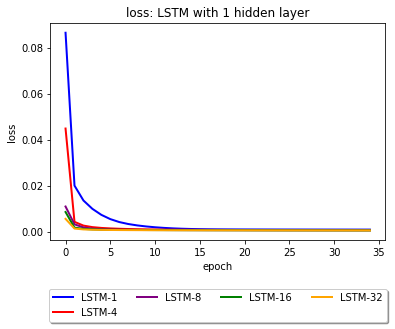

In [105]:
loss1_1, loss4_1, loss8_1, loss16_1, loss32_1 = history1_1.history["loss"],\
history4_1.history["loss"], history8_1.history["loss"], \
history16_1.history["loss"], history32_1.history["loss"]

loss = [loss1_1, loss4_1, loss8_1, loss16_1, loss32_1]
color = ["blue", "red", "purple","green", "orange"]
model = ["LSTM-1", "LSTM-4", "LSTM-8", "LSTM-16", "LSTM-32"]
epochs = [i for i in range(35)]
for l, c, m in zip(loss, color, model):
    plt.plot(epochs, l, color = c, lw = 2,label = m)
plt.title("loss: LSTM with 1 hidden layer")
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2), fancybox=True , shadow=True, ncol=4)
plt.show()

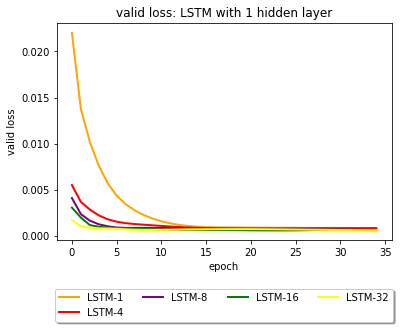

In [106]:
valid_loss1_1, valid_loss4_1, valid_loss8_1, valid_loss16_1, valid_loss32_1 = history1_1.history["val_loss"],\
history4_1.history["val_loss"], history8_1.history["val_loss"], \
history16_1.history["val_loss"], history32_1.history["val_loss"]

val_loss = [valid_loss1_1, valid_loss4_1, valid_loss8_1, valid_loss16_1, valid_loss32_1]
color = ["orange", "red", "purple","green", "yellow"]
model = ["LSTM-1", "LSTM-4", "LSTM-8", "LSTM-16", "LSTM-32"]
epochs = [i for i in range(35)]
for l, c, m in zip(val_loss, color, model):
    plt.plot(epochs, l, color = c, lw = 2,label = m)
plt.title("valid loss: LSTM with 1 hidden layer")
plt.ylabel('valid loss')
plt.xlabel('epoch')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2), fancybox=True , shadow=True, ncol=4)
plt.show()

In [107]:
def loss_train_valid_1(loss, val_loss, model, N):
    epochs = [i for i in range(35)]
    plt.plot(epochs, loss)
    plt.plot(epochs, val_loss)
    plt.title("{} loss: LSTM {}". format(model, N))
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['training', 'validation'], loc='best')
    plt.show()

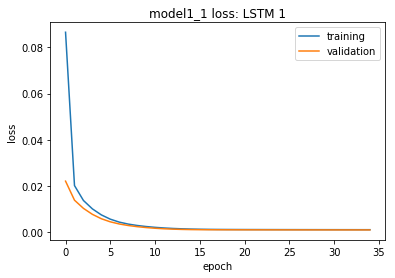

In [108]:
loss_train_valid_1(loss1_1, valid_loss1_1, 'model1_1', 1)

#### RMSE and SMAPE compariosn across the models

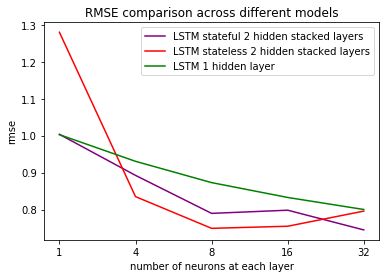

In [110]:
# RMSE comparison

rmse_sf = [rmse1, rmse4, rmse8, rmse16, rmse32]
smape_sf = [smape1, smape4, smape8, smape16, smape32]

rmse_sl = [rmse1_sl, rmse4_sl,rmse8_sl, rmse16_sl, rmse32_sl]
smape_sl = [smape1_sl, smape4_sl,smape8_sl, smape16_sl, smape32_sl]

rmse_1 = [rmse1_1, rmse4_1,rmse8_1, rmse16_1, rmse32_1]
smape_1 = [smape1_1, smape4_1,smape8_1, smape16_1, smape32_1]

N = ['1', '4', '8', '16', '32']

plt.plot(N, rmse_sf, color = "purple", label ="LSTM stateful 2 hidden stacked layers" )
plt.plot(N, rmse_sl, color = "red",label ="LSTM stateless 2 hidden stacked layers")
plt.plot(N, rmse_1, color = "green",label ="LSTM 1 hidden layer")
plt.xlabel("number of neurons at each layer")
plt.ylabel("rmse")
plt.legend(loc='upper right')
plt.title("RMSE comparison across different models")
plt.show()
    
    
    

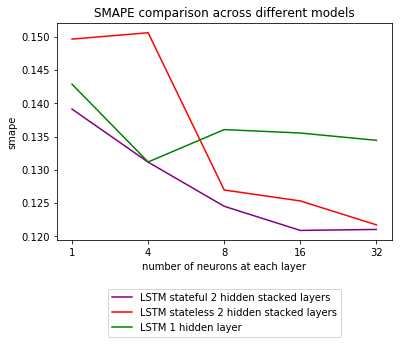

In [111]:
plt.plot(N, smape_sf, color = "purple", label ="LSTM stateful 2 hidden stacked layers" )
plt.plot(N, smape_sl, color = "red",label ="LSTM stateless 2 hidden stacked layers")
plt.plot(N, smape_1, color = "green",label ="LSTM 1 hidden layer")
plt.xlabel("number of neurons at each layer")
plt.ylabel("smape")
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2))
plt.title("SMAPE comparison across different models")
plt.show()
    

### 4.4 Stateful stacked LSTM with 3 hidden layers

The five different stacked LSTM networks are created with 3 hidden layers and the same number of units at each layer. The observed number of units is:  1, 4, 8, 16 and 32.

In [112]:
def create_model_sf(x_train, y_train, x_valid, y_valid, N, batch_size, no_epochs):
    loss, valid_loss =list(), list()
    model = Sequential()
    model.add(LSTM(N, batch_input_shape = (batch_size, x_train.shape[1], x_train.shape[2]), \
                   stateful = True,return_sequences = True))
    model.add(LSTM(N, batch_input_shape = (batch_size, x_train.shape[1], x_train.shape[2]), \
                   stateful = True, return_sequences = True))
    model.add(LSTM(N, batch_input_shape = (batch_size, x_train.shape[1], x_train.shape[2]), \
                   stateful = True, return_sequences = False))
    model.add(Dense(1))
    model.compile(loss ="mse", optimizer ="adam")
    loss, valid_loss = list(), list()
    for i in range(no_epochs):
        #print("Epoch: " + str(i))
        history = model.fit(x_train,y_train, shuffle=False, epochs = 1, \
                            batch_size=batch_size, verbose = 0, validation_data=(x_valid, y_valid))
        
        loss.append(history.history['loss'])
        valid_loss.append(history.history['val_loss'])
        model.reset_states()
    return model, loss, valid_loss  

In [113]:
model1_sf,loss1_sf,valid_loss1_sf = create_model_sf(x_train, y_train, x_valid, y_valid,\
                    N =1 ,batch_size =73, no_epochs = 35 )
model4_sf,loss4_sf,valid_loss4_sf = create_model_sf(x_train, y_train, x_valid, y_valid,\
                    N =4 ,batch_size =73, no_epochs = 35 )
model8_sf,loss8_sf,valid_loss8_sf = create_model_sf(x_train, y_train, x_valid, y_valid, \
                    N =8 , batch_size =73, no_epochs = 35)
model16_sf,loss16_sf,valid_loss16_sf = create_model_sf(x_train, y_train, x_valid, y_valid,\
                    N =16 , batch_size =73, no_epochs = 35)
model32_sf,loss32_sf,valid_loss32_sf = create_model_sf(x_train, y_train, x_valid, y_valid,\
                    N =32 , batch_size =73, no_epochs = 35)

In [114]:
yhat1_sf = model_predict(model1_sf, x_test, batch_size =73)
yhat4_sf = model_predict(model4_sf, x_test, batch_size =73)
yhat8_sf = model_predict(model8_sf, x_test, batch_size =73)
yhat16_sf = model_predict(model16_sf, x_test, batch_size =73)
yhat32_sf = model_predict(model32_sf, x_test, batch_size =73)

In [115]:
yhat1_inv_sf = data_inversion(yhat1_sf)
yhat4_inv_sf = data_inversion(yhat4_sf)
yhat8_inv_sf = data_inversion(yhat8_sf)
yhat16_inv_sf = data_inversion(yhat16_sf)
yhat32_inv_sf = data_inversion(yhat32_sf)
y_test_inv = data_inversion(y_test)

In [116]:
rmse1_sf, smape1_sf = calculate_error(yhat1_inv_sf, y_test_inv)

Test RMSE: 1.011
Test SMAPE: 0.139


In [117]:
rmse4_sf, smape4_sf = calculate_error(yhat4_inv_sf, y_test_inv)

Test RMSE: 0.792
Test SMAPE: 0.138


In [118]:
rmse8_sf, smape8_sf = calculate_error(yhat8_inv_sf, y_test_inv)

Test RMSE: 0.766
Test SMAPE: 0.139


In [119]:
rmse16_sf, smape16_sf = calculate_error(yhat16_inv_sf, y_test_inv)

Test RMSE: 0.767
Test SMAPE: 0.123


In [120]:
rmse32_sf, smape32_sf = calculate_error(yhat32_inv_sf, y_test_inv)

Test RMSE: 0.768
Test SMAPE: 0.121


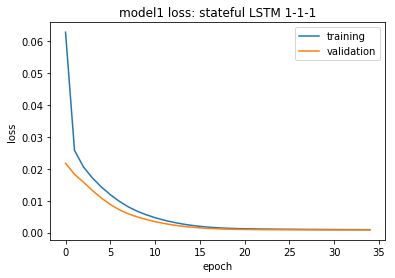

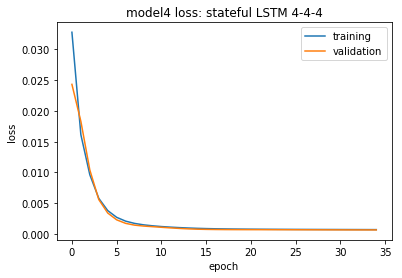

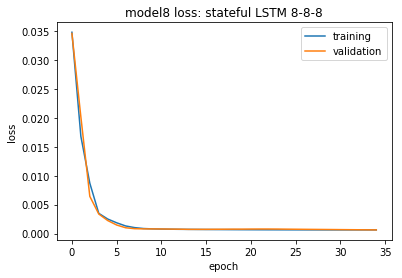

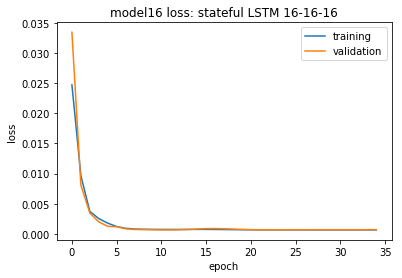

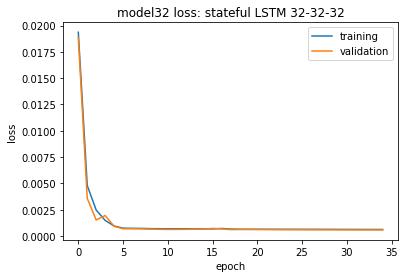

In [121]:
loss_train_valid (loss1_sf, valid_loss1_sf, 'model1', 1)
loss_train_valid (loss4_sf, valid_loss4_sf, 'model4', 4)
loss_train_valid (loss8_sf, valid_loss8_sf, 'model8', 8)
loss_train_valid (loss16_sf, valid_loss16_sf, 'model16', 16)
loss_train_valid (loss32_sf, valid_loss32_sf, 'model32', 32)

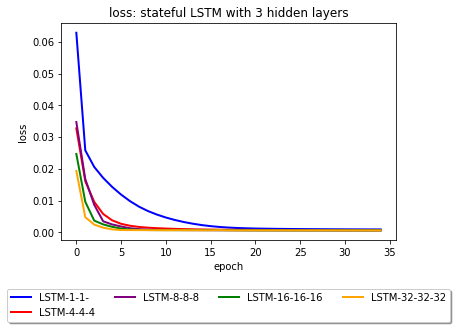

In [122]:
# train loss comaprison over all five models

loss = [loss1_sf, loss4_sf, loss8_sf, loss16_sf, loss32_sf]
color = ["blue", "red", "purple","green", "orange"]
model = ["LSTM-1-1-", "LSTM-4-4-4", "LSTM-8-8-8", "LSTM-16-16-16", "LSTM-32-32-32"]
epochs = [i for i in range(35)]
for l, c, m in zip(loss, color, model):
    plt.plot(epochs, l, color = c, lw = 2,label = m)
plt.title("loss: stateful LSTM with 3 hidden layers")
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2), fancybox=True , shadow=True, ncol=4)
plt.show()

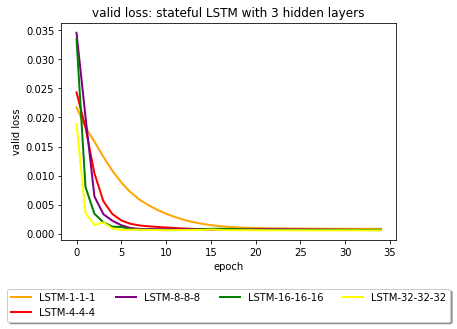

In [123]:
val_loss = [valid_loss1_sf, valid_loss4_sf, valid_loss8_sf, valid_loss16_sf, valid_loss32_sf]
color = ["orange", "red", "purple","green", "yellow"]
model = ["LSTM-1-1-1", "LSTM-4-4-4", "LSTM-8-8-8", "LSTM-16-16-16", "LSTM-32-32-32"]
epochs = [i for i in range(35)]
for l, c, m in zip(val_loss, color, model):
    plt.plot(epochs, l, color = c, lw = 2,label = m)
plt.title("valid loss: stateful LSTM with 3 hidden layers")
plt.ylabel('valid loss')
plt.xlabel('epoch')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2), fancybox=True , shadow=True, ncol=4)
plt.show()

### 4.5. Stateless stacked LSTM with 3 hidden layers

The five different stacked LSTM networks are created with 3 hidden layers and the same number of units at each layer. The observed number of units is:  1, 4, 8, 16 and 32.

In [124]:
def create_model_sl_1(x_train, y_train, x_valid, y_valid, N, batch_size, no_epochs):
    model = Sequential()
    model.add(LSTM(N, batch_input_shape = (batch_size, x_train.shape[1], x_train.shape[2]), \
                   stateful = False,return_sequences = True))
    model.add(LSTM(N, batch_input_shape = (batch_size, x_train.shape[1], x_train.shape[2]), \
                   stateful = False, return_sequences = True))
    model.add(LSTM(N, batch_input_shape = (batch_size, x_train.shape[1], x_train.shape[2]), \
                   stateful = False, return_sequences = False))
    model.add(Dense(1))
    model.compile(loss ="mse", optimizer ="adam")
    history = model.fit(x_train,y_train, shuffle=False, epochs = no_epochs, \
                            batch_size=batch_size, verbose = 0, validation_data=(x_valid, y_valid))
    return model, history 

In [125]:
model1_sl_1, history1_sl_1 = create_model_sl_1(x_train, y_train, x_valid, y_valid,\
                    N =1 ,batch_size =73, no_epochs = 35 )
model4_sl_1, history4_sl_1 = create_model_sl_1(x_train, y_train, x_valid, y_valid,\
                    N =4 ,batch_size =73, no_epochs = 35 )
model8_sl_1, history8_sl_1 = create_model_sl_1(x_train, y_train, x_valid, y_valid, \
                    N =8 , batch_size =73, no_epochs = 35)
model16_sl_1, history16_sl_1 = create_model_sl_1(x_train, y_train, x_valid, y_valid,\
                    N =16 , batch_size =73, no_epochs = 35)
model32_sl_1, history32_sl_1 = create_model_sl_1(x_train, y_train, x_valid, y_valid,\
                    N =32 , batch_size =73, no_epochs = 35)

In [126]:
yhat1_sl_1 = model_predict(model1_sl_1, x_test, batch_size =73)
yhat4_sl_1 = model_predict(model4_sl_1, x_test, batch_size =73)
yhat8_sl_1 = model_predict(model8_sl_1, x_test, batch_size =73)
yhat16_sl_1 = model_predict(model16_sl_1, x_test, batch_size =73)
yhat32_sl_1 = model_predict(model32_sl_1, x_test, batch_size =73)

In [127]:
yhat1_inv_sl_1 = data_inversion(yhat1_sl_1)
yhat4_inv_sl_1 = data_inversion(yhat4_sl_1)
yhat8_inv_sl_1 = data_inversion(yhat8_sl_1)
yhat16_inv_sl_1 = data_inversion(yhat16_sl_1)
yhat32_inv_sl_1 = data_inversion(yhat32_sl_1)
#y_test_inv = data_inversion(y_test)

In [128]:
rmse1_sl_1, smape1_sl_1 = calculate_error(yhat1_inv_sl_1, y_test_inv)

Test RMSE: 1.220
Test SMAPE: 0.154


In [129]:
rmse4_sl_1, smape4_sl_1 = calculate_error(yhat4_inv_sl_1, y_test_inv)

Test RMSE: 0.825
Test SMAPE: 0.139


In [130]:
rmse8_sl_1, smape8_sl_1 = calculate_error(yhat8_inv_sl_1, y_test_inv)

Test RMSE: 0.781
Test SMAPE: 0.137


In [131]:
rmse16_sl_1, smape16_sl_1 = calculate_error(yhat16_inv_sl_1, y_test_inv)

Test RMSE: 0.834
Test SMAPE: 0.126


In [132]:
rmse32_sl_1, smape32_sl_1 = calculate_error(yhat32_inv_sl_1, y_test_inv)

Test RMSE: 0.784
Test SMAPE: 0.130


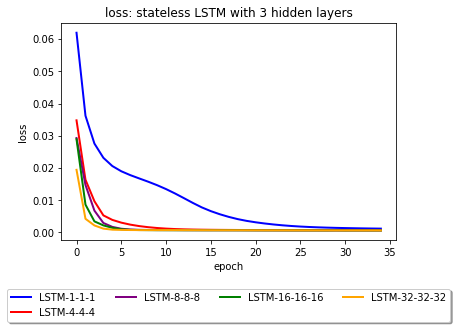

In [133]:
loss1_sl_1, loss4_sl_1, loss8_sl_1, loss16_sl_1, loss32_sl_1 = history1_sl_1.history["loss"],\
history4_sl_1.history["loss"], history8_sl_1.history["loss"], \
history16_sl_1.history["loss"], history32_sl_1.history["loss"]

loss = [loss1_sl_1, loss4_sl_1, loss8_sl_1, loss16_sl_1, loss32_sl_1]
color = ["blue", "red", "purple","green", "orange"]
model = ["LSTM-1-1-1", "LSTM-4-4-4", "LSTM-8-8-8", "LSTM-16-16-16", "LSTM-32-32-32"]
epochs = [i for i in range(35)]
for l, c, m in zip(loss, color, model):
    plt.plot(epochs, l, color = c, lw = 2,label = m)
plt.title("loss: stateless LSTM with 3 hidden layers")
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2), fancybox=True , shadow=True, ncol=4)
plt.show()

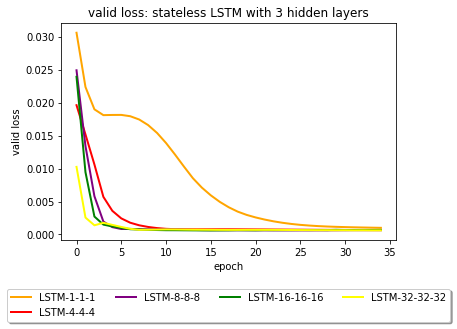

In [134]:
valid_loss1_sl_1, valid_loss4_sl_1, valid_loss8_sl_1, valid_loss16_sl_1, valid_loss32_sl_1 = history1_sl_1.history["val_loss"],\
history4_sl_1.history["val_loss"], history8_sl_1.history["val_loss"], \
history16_sl_1.history["val_loss"], history32_sl_1.history["val_loss"]

val_loss = [valid_loss1_sl_1, valid_loss4_sl_1, valid_loss8_sl_1, valid_loss16_sl_1, valid_loss32_sl_1]
color = ["orange", "red", "purple","green", "yellow"]
model = ["LSTM-1-1-1", "LSTM-4-4-4", "LSTM-8-8-8", "LSTM-16-16-16", "LSTM-32-32-32"]
epochs = [i for i in range(35)]
for l, c, m in zip(val_loss, color, model):
    plt.plot(epochs, l, color = c, lw = 2,label = m)
plt.title("valid loss: stateless LSTM with 3 hidden layers")
plt.ylabel('valid loss')
plt.xlabel('epoch')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2), fancybox=True , shadow=True, ncol=4)
plt.show()

### 5. RMSE and SMAPE Comparison accross all models

#### here we compare RMSE and SMAPE for all 15 models

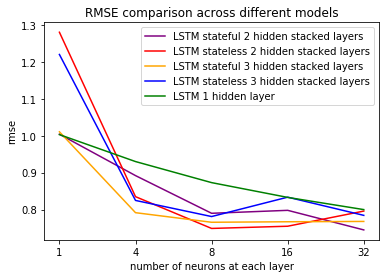

In [136]:
# RMSE comparison

rmse_sf_2 = [rmse1, rmse4, rmse8, rmse16, rmse32]
smape_sf_2 = [smape1, smape4, smape8, smape16, smape32]

rmse_sf_3 = [rmse1_sf, rmse4_sf, rmse8_sf, rmse16_sf, rmse32_sf]
smape_sf_3 = [smape1_sf, smape4_sf, smape8_sf, smape16_sf, smape32_sf]

rmse_sl_2 = [rmse1_sl, rmse4_sl,rmse8_sl, rmse16_sl, rmse32_sl]
smape_sl_2 = [smape1_sl, smape4_sl,smape8_sl, smape16_sl, smape32_sl]

rmse_sl_3 = [rmse1_sl_1, rmse4_sl_1,rmse8_sl_1, rmse16_sl_1, rmse32_sl_1]
smape_sl_3 = [smape1_sl_1, smape4_sl_1,smape8_sl_1, smape16_sl_1, smape32_sl_1]

rmse_1 = [rmse1_1, rmse4_1,rmse8_1, rmse16_1, rmse32_1]
smape_1 = [smape1_1, smape4_1,smape8_1, smape16_1, smape32_1]

N = ['1', '4', '8', '16', '32']

plt.plot(N, rmse_sf_2, color = "purple", label ="LSTM stateful 2 hidden stacked layers" )
plt.plot(N, rmse_sl_2, color = "red",label ="LSTM stateless 2 hidden stacked layers")
plt.plot(N, rmse_sf_3, color = "orange", label ="LSTM stateful 3 hidden stacked layers" )
plt.plot(N, rmse_sl_3, color = "blue",label ="LSTM stateless 3 hidden stacked layers")
plt.plot(N, rmse_1, color = "green",label ="LSTM 1 hidden layer")
plt.xlabel("number of neurons at each layer")
plt.ylabel("rmse")
plt.legend(loc='upper right')
plt.title("RMSE comparison across different models")
plt.show()
    
    

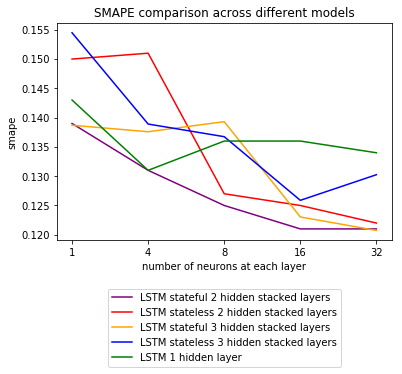

In [137]:
plt.plot(N, smape_sf_2, color = "purple", label ="LSTM stateful 2 hidden stacked layers" )
plt.plot(N, smape_sl_2, color = "red",label ="LSTM stateless 2 hidden stacked layers")
plt.plot(N, smape_sf_3, color = "orange", label ="LSTM stateful 3 hidden stacked layers" )
plt.plot(N, smape_sl_3, color = "blue",label ="LSTM stateless 3 hidden stacked layers")
plt.plot(N, smape_1, color = "green",label ="LSTM 1 hidden layer")
plt.xlabel("number of neurons at each layer")
plt.ylabel("smape")
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2))
plt.title("SMAPE comparison across different models")
plt.show()

In [138]:
def plot_prediction(yhat_inv, y_test_inv, i):
    fig = plt.figure()
    ax1 = fig.add_subplot(111)
    ax1.scatter(range(len(yhat_inv)),y_test_inv,alpha = 0.5,lw =0, s=10, c='b',label='test values')
    ax1.scatter(range(len(yhat_inv)),yhat_inv,alpha = 0.5,lw =0, s=10, c='r', label='predictions')
    plt.legend(loc='upper left')
    plt.title("test vs prediction: stateless: LSTM-{}-{}-{}". format(i,i,i))
    plt.show()

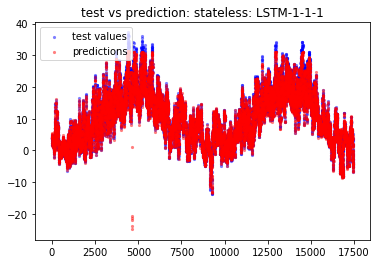

In [139]:
plot_prediction(yhat1_inv_sl_1, y_test_inv, 1)

In [140]:
def loss_train_valid_sl(loss, val_loss, model, N):
    epochs = [i for i in range(35)]
    plt.plot(epochs, loss)
    plt.plot(epochs, val_loss)
    plt.title("{} stateless loss: LSTM {}-{}-{}". format(model, N,N,N))
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['training', 'validation'], loc='best')
    plt.show()

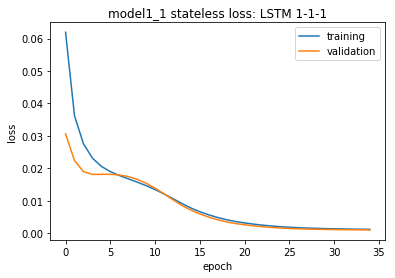

In [141]:
loss_train_valid_sl(loss1_sl_1, valid_loss1_sl_1, 'model1_1', 1)

### 6. T-test


####  6.1 t-test stateful and stateless

We perform the paired t-test between stateful model with 2 layers and 32 unit and stateless model with 2 layers and 8 units
We repeat the training of ecah model 8 times.

In [143]:
error_sf, y_hat_sf, smape_sf = list(), list(), list()
for i in range(8):
    model32, loss32, valid_loss32 = create_model(x_train, y_train, x_valid, y_valid,\
                    N =32 , batch_size =73, no_epochs = 35)
    yhat32 = model_predict(model32, x_test, batch_size =73)
    yhat32_inv = data_inversion(yhat32)
    rmse32, smape32 = calculate_error(yhat32_inv, y_test_inv)
    error_sf.append(rmse32)
    smape_sf.append(smape32)
    y_hat_sf.append(yhat32_inv)

Test RMSE: 0.774
Test SMAPE: 0.119
Test RMSE: 0.777
Test SMAPE: 0.118
Test RMSE: 0.728
Test SMAPE: 0.118
Test RMSE: 0.747
Test SMAPE: 0.126
Test RMSE: 0.757
Test SMAPE: 0.121
Test RMSE: 0.753
Test SMAPE: 0.128
Test RMSE: 0.735
Test SMAPE: 0.119
Test RMSE: 0.821
Test SMAPE: 0.133


In [144]:
error_sf

[0.7742625382415176,
 0.7770552519457111,
 0.7281291397923668,
 0.7469594576342901,
 0.7565767492009682,
 0.7527426827079974,
 0.7349479659915951,
 0.821118903014723]

In [145]:
yhat_df = pd.DataFrame(y_hat_sf[2], index = submission.index.values)

In [146]:
submission_new = pd.concat([submission, yhat_df], axis =1)

In [147]:
head = ['date time','yhat']
submission_new.to_csv('NEW_submission_SF.csv', index=False, header=head)

In [149]:
error_sl, y_hat_sl, smape_sl = list(), list(), list()
for i in range(8):
    model8_sl, history8_sl = create_model_sl(x_train, y_train, x_valid, y_valid, \
                    N =8 , batch_size =73, no_epochs = 35)
    yhat8_sl = model_predict(model8_sl, x_test, batch_size =73)
    yhat8_inv_sl = data_inversion(yhat8_sl)
    rmse8_sl, smape8_sl = calculate_error(yhat8_inv_sl, y_test_inv)
    error_sl.append(rmse8_sl)
    smape_sl.append(smape8_sl)
    y_hat_sl.append(yhat8_inv_sl)

Test RMSE: 0.770
Test SMAPE: 0.133
Test RMSE: 0.761
Test SMAPE: 0.122
Test RMSE: 0.746
Test SMAPE: 0.130
Test RMSE: 0.861
Test SMAPE: 0.151
Test RMSE: 0.792
Test SMAPE: 0.125
Test RMSE: 0.794
Test SMAPE: 0.153
Test RMSE: 0.747
Test SMAPE: 0.124
Test RMSE: 0.766
Test SMAPE: 0.126


In [151]:
mu_sf = np.mean(error_sf)
var_sf = np.var(error_sf)
mu_sl = np.mean(error_sl)
var_sl = np.var(error_sl)

In [153]:
mu_sf, mu_sl

(0.7614740860661462, 0.77965339796307)

In [172]:
var_sf, var_sl

(0.000761279708467103, 0.0012292738152271216)

In [159]:
values = error_sf+error_sl

In [164]:
models = 8*["Stateful 32-32"]+8*["Stateless 8-8"]

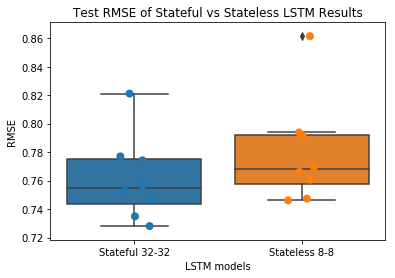

In [169]:
# The error/RMSE spread out of the two models

models = 8*["Stateful 32-32"]+8*["Stateless 8-8"]
values = error_sf+error_sl
df = pd.DataFrame(
    {'LSTM models': models,
     'RMSE': values
    })

import seaborn as sns
sns.boxplot(x='LSTM models', y='RMSE', data=df)
ax = sns.stripplot(x='LSTM models', y='RMSE', data=df,
              size=8, jitter=True, edgecolor="gray", linewidth=0.01)
#handles, labels = ax.get_legend_handles_labels()
#l = plt.legend(handles[0:4], labels[0:4], bbox_to_anchor=(1.05, 1), loc=
#2, borderaxespad=0.)
plt.title('Test RMSE of Stateful vs Stateless LSTM Results')
plt.show()

In [170]:
from scipy import stats
t_test, p_test = stats.ttest_ind(error_sl, error_sf)

In [171]:
# we can see that p value is higher than 0.05
t_test, p_test

(1.0780515563607802, 0.2992359159860467)

####  6.2 t-test stateful 'mse' and 'mae'
- Stateful model 2 layers and 32 units
- We switch the loss function from "mse" to "mae" and check the differences in RMSE values 


In [174]:
error_sf, y_hat_sf, smape_sf = list(), list(), list()
for i in range(8):
    model32_mae, loss32, valid_loss32 = create_model_mae(x_train, y_train, x_valid, y_valid,\
                    N =32 , batch_size =73, no_epochs = 35)
    yhat32_mae = model_predict(model32_mae, x_test, batch_size =73)
    yhat32_inv_mae = data_inversion(yhat32_mae)
    rmse32_mae, smape32_mae = calculate_error(yhat32_inv_mae, y_test_inv)
    error_sf.append(rmse32_mae)
    smape_sf.append(smape32_mae)
    y_hat_sf.append(yhat32_inv_mae)

Test RMSE: 0.802
Test SMAPE: 0.125
Test RMSE: 0.796
Test SMAPE: 0.122
Test RMSE: 0.732
Test SMAPE: 0.125
Test RMSE: 0.888
Test SMAPE: 0.132
Test RMSE: 0.923
Test SMAPE: 0.138
Test RMSE: 0.877
Test SMAPE: 0.126
Test RMSE: 0.796
Test SMAPE: 0.117
Test RMSE: 0.863
Test SMAPE: 0.139


In [175]:
error_sf_1 = [0.7742625382415176,
 0.7770552519457111,
 0.7281291397923668,
 0.7469594576342901,
 0.7565767492009682,
 0.7527426827079974,
 0.7349479659915951,
 0.821118903014723]

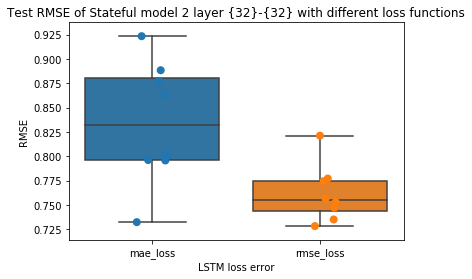

In [177]:
loss = 8*["mae_loss"]+8*["rmse_loss"]
values = error_sf+error_sf_1
df = pd.DataFrame(
    {'LSTM loss error': loss,
     'RMSE': values
    })

import seaborn as sns
sns.boxplot(x='LSTM loss error', y='RMSE', data=df)
ax = sns.stripplot(x='LSTM loss error', y='RMSE', data=df,
              size=8, jitter=True, edgecolor="gray", linewidth=0.01)
#handles, labels = ax.get_legend_handles_labels()
#l = plt.legend(handles[0:4], labels[0:4], bbox_to_anchor=(1.05, 1), loc=
#2, borderaxespad=0.)
plt.title('Test RMSE of Stateful model 2 layer {32}-{32} with different loss functions')
plt.show()

In [178]:
mu_sf = np.mean(error_sf)
mu_sf_1 = np.mean(error_sf_1)


In [179]:
mu_sf, mu_sf_1

(0.834795459892351, 0.7614740860661462)

In [180]:
# we can see that p value is less than 0.01
from scipy import stats
t_test, p_test = stats.ttest_ind(error_sf, error_sf_1)

In [181]:
t_test, p_test

(2.9715391201028147, 0.010105602932488153)

####  6.3 t-test stateful '32 units' and '44 units'

In [181]:
# Stateful model 2 layers and 32 units

In [183]:
# We switch the number of units from "32" to "44" and check the differences in RMSE values 

In [190]:
error_sf, y_hat_sf, smape_sf = list(), list(), list()
for i in range(8):
    model44, loss44, valid_loss44 = create_model(x_train, y_train, x_valid, y_valid,\
                    N =44 , batch_size =73, no_epochs = 35)
    yhat44 = model_predict(model44, x_test, batch_size =73)
    yhat44_inv = data_inversion(yhat44)
    rmse44, smape44 = calculate_error(yhat44_inv, y_test_inv)
    error_sf.append(rmse44)
    smape_sf.append(smape44)
    y_hat_sf.append(yhat44_inv)

Test RMSE: 0.808
Test SMAPE: 0.121
Test RMSE: 0.769
Test SMAPE: 0.118
Test RMSE: 0.828
Test SMAPE: 0.132
Test RMSE: 0.766
Test SMAPE: 0.119
Test RMSE: 0.797
Test SMAPE: 0.121
Test RMSE: 0.734
Test SMAPE: 0.119
Test RMSE: 0.752
Test SMAPE: 0.120
Test RMSE: 0.758
Test SMAPE: 0.121


In [192]:
mu_sf = np.mean(error_sf)
mu_sf_1 = np.mean(error_sf_1)

In [193]:
mu_sf, mu_sf_1

(0.7765792533795943, 0.7614740860661462)

In [194]:
from scipy import stats
t_test, p_test = stats.ttest_ind(error_sf, error_sf_1)

In [195]:
t_test, p_test

(0.9894419781087119, 0.339240295729787)

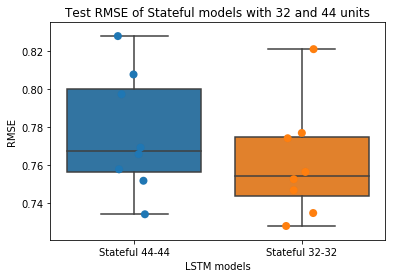

In [196]:
models = 8*["Stateful 44-44"]+8*["Stateful 32-32"]
values = error_sf+error_sf_1
df = pd.DataFrame(
    {'LSTM models': models,
     'RMSE': values
    })

import seaborn as sns
sns.boxplot(x='LSTM models', y='RMSE', data=df)
ax = sns.stripplot(x='LSTM models', y='RMSE', data=df,
              size=8, jitter=True, edgecolor="gray", linewidth=0.01)
#handles, labels = ax.get_legend_handles_labels()
#l = plt.legend(handles[0:4], labels[0:4], bbox_to_anchor=(1.05, 1), loc=
#2, borderaxespad=0.)
plt.title('Test RMSE of Stateful models with 32 and 44 units')
plt.show()